## Lab 3

### Part 3. Poetry generation

Let's try to generate some poetry using RNNs. 

You have several choices here: 

* The Shakespeare sonnets, file `sonnets.txt` available in the notebook directory.

* Роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина. В предобработанном виде доступен по [ссылке](https://github.com/attatrol/data_sources/blob/master/onegin.txt).

* Some other text source, if it will be approved by the course staff.

Text generation can be designed in several steps:
    
1. Data loading.
2. Dictionary generation.
3. Data preprocessing.
4. Model (neural network) training.
5. Text generation (model evaluation).


### Data loading: "Евгений Онегин"


In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [1]:
import numpy as np
import string
import re
import os

In [2]:
with open('onegin.txt', 'r') as iofile:
    text = iofile.readlines()
    
text = np.array([re.sub('[^а-я ]', '', x.lower()) for x in text])
lens = np.array([len(text[i]) for i in range(text.size)])
processed = text[(lens > 10) & (lens < 40)]
out = '\n'.join(processed)

Put all the characters, that you've seen in the text, into variable `tokens`.

In [3]:
tokens = list(sorted(set(out)))
num_tokens = len(tokens)

In [4]:
data = processed.tolist()
MAX_LENGTH = max(map(len, data))

Create dictionary `token_to_idx = {<char>: <index>}` and dictionary `idx_to_token = {<index>: <char>}`

In [5]:
token_to_inx = {token: inx for inx, token in enumerate(tokens)}
inx_to_token = {inx: token for token, inx in token_to_inx.items()}

*Comment: in this task we have only 38 different tokens, so let's use one-hot encoding.*

### Building the model

Now we want to build and train recurrent neural net which would be able to something similar to Shakespeare's poetry.

Let's use vanilla RNN, similar to the one created during the lesson.

In [6]:
def to_matrix(data, max_len=None, pad=token_to_inx[' '], dtype='int32', batch_first = True):
    """Casts a list of string into rnn-digestable matrix"""
    
    max_len = max_len or max(map(len, data))
    data_ix = np.zeros([len(data), max_len], dtype) + pad

    for i in range(len(data)):
        line_ix = [token_to_inx[c] for c in data[i]]
        data_ix[i, :len(line_ix)] = line_ix
        
    if not batch_first: # convert [batch, time] into [time, batch]
        data_ix = np.transpose(data_ix)

    return data_ix

In [7]:
print(out[:103])
print(to_matrix(processed[:4]))

мой дядя самых честных правил
когда не в шутку занемог
он уважать себя заставил
и лучше выдумать не мог
[[14 16 11  1  6 33  6 33  1 19  2 14 29 23  1 25  7 19 20 15 29 23  1 17
  18  2  4 10 13]
 [12 16  5  6  2  1 15  7  1  4  1 26 21 20 12 21  1  9  2 15  7 14 16  5
   1  1  1  1  1]
 [16 15  1 21  4  2  8  2 20 30  1 19  7  3 33  1  9  2 19 20  2  4 10 13
   1  1  1  1  1]
 [10  1 13 21 25 26  7  1  4 29  6 21 14  2 20 30  1 15  7  1 14 16  5  1
   1  1  1  1  1]]


In [8]:
import torch, torch.nn as nn
import torch.nn.functional as F

In [9]:
class CharRNNCell(nn.Module):
    """
    Implement the scheme above as torch module
    """
    def __init__(self, num_tokens=len(tokens), embedding_size=16, rnn_num_units=64):
        super(self.__class__,self).__init__()
        self.num_units = rnn_num_units
        
        self.embedding = nn.Embedding(num_tokens, embedding_size)
        self.rnn_update = nn.Linear(embedding_size + rnn_num_units, rnn_num_units)
        self.rnn_to_logits = nn.Linear(rnn_num_units, num_tokens)
        
    def forward(self, x, h_prev):
        """
        This method computes h_next(x, h_prev) and log P(x_next | h_next)
        We'll call it repeatedly to produce the whole sequence.
        
        :param x: batch of character ids, containing vector of int64
        :param h_prev: previous rnn hidden states, containing matrix [batch, rnn_num_units] of float32
        """
        
        x_emb = self.embedding(x)
        x_and_h = torch.cat([x_emb, h_prev], dim=1)
        h_next = self.rnn_update(x_and_h)
        h_next = torch.tanh(h_next)
        
        assert h_next.size() == h_prev.size()
        
        logits = self.rnn_to_logits(h_next)
        
        return h_next, F.log_softmax(logits, -1)
    
    def initial_state(self, batch_size):
        """ return rnn state before it processes first input (aka h0) """
        return torch.zeros(batch_size, self.num_units, requires_grad=True)

In [10]:
def rnn_loop(model, batch_ix):
    """
    Computes log P(next_character) for all time-steps in names_ix
    :param names_ix: an int32 matrix of shape [batch, time], output of to_matrix(names)
    """
    batch_size, max_length = batch_ix.size()
    hid_state = model.initial_state(batch_size)
    logprobs = []

    for x_t in batch_ix.transpose(0,1):
        hid_state, logits = model(x_t, hid_state)  # <-- here we call your one-step code
        logprobs.append(F.log_softmax(logits, -1))
        
    return torch.stack(logprobs, dim=1)

In [11]:
from IPython.display import clear_output
from random import sample

char_rnn = CharRNNCell()
criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(char_rnn.parameters())
history = []

Plot the loss function (axis X: number of epochs, axis Y: loss function).

In [12]:
import matplotlib.pyplot as plt

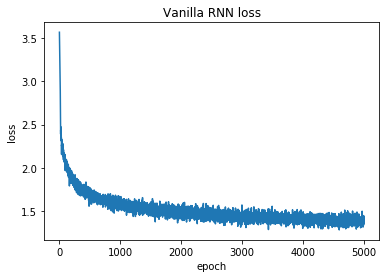

In [13]:
for i in range(5000):
    batch_ix = to_matrix(sample(data, 32), max_len=MAX_LENGTH)
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64)
    
    logp_seq = rnn_loop(char_rnn, batch_ix)
    
    # compute loss
    predictions_logp = logp_seq[:, :-1]
    actual_next_tokens = batch_ix[:, 1:]

    optimizer.zero_grad()
    
    loss = criterion(predictions_logp.contiguous().view(-1, len(tokens)), actual_next_tokens.contiguous().view(-1))
    
    loss.backward()
    optimizer.step()
    
    history.append(loss.data.numpy())
    if (i+1)%100==0:
        clear_output(True)
        plt.plot(history)
        plt.title("Vanilla RNN loss")
        plt.xlabel("epoch")
        plt.ylabel("loss")
        plt.show()

assert np.mean(history[:10]) > np.mean(history[-10:]), "RNN didn't converge."

In [14]:
def generate_sample(model, seed_phrase=' ', max_length=MAX_LENGTH, temperature=1.0):
    '''
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs,
                        smaller temperature converges to the single most likely output
    '''
    
    x_sequence = [token_to_inx[token] for token in seed_phrase]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64)
    hid_state = model.initial_state(batch_size=1)
    
    #feed the seed phrase, if any
    for i in range(len(seed_phrase) - 1):
        hid_state, _ = model(x_sequence[:, i], hid_state)
    
    #start generating
    for _ in range(max_length - len(seed_phrase)):
        hid_state, logits = model(x_sequence[:, -1], hid_state)
        p_next = F.softmax(logits / temperature, dim=-1).data.numpy()[0]
        
        # sample next token and push it back into x_sequence
        next_ix = np.random.choice(num_tokens,p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)
        
    return ''.join([tokens[ix] for ix in x_sequence.data.numpy()[0]])

In [15]:
for _ in range(10):
    print(generate_sample(char_rnn, seed_phrase=' ', max_length=20, temperature=1.2))

   в так окназений и
 так яв текно на сво
 дам биззакая тьбинв
 лагожет в свилей го
 влячет колюбягим су
 как я пулетванны   
 ром этхуб юмета под
 это блое мелеци    
 юн свеятша потсчета
 твлучье ок нечстыю 


### More poetic model

Let's use LSTM instead of vanilla RNN and compare the results.

In [16]:
class CharLSTMCell(nn.Module):
    def __init__(self, num_tokens=len(tokens), embedding_size=MAX_LENGTH, rnn_num_units=64):
        super(self.__class__,self).__init__()
        self.num_units = rnn_num_units
        self.emb = nn.Embedding(num_tokens, embedding_size)
        self.lstm = nn.LSTMCell(embedding_size, rnn_num_units)
        self.rnn_to_logits = nn.Linear(rnn_num_units, num_tokens)
        
    def forward(self, x, prev_state):
        (prev_h, prev_c) = prev_state
        (next_h, next_c) = self.lstm(self.emb(x), (prev_h, prev_c))
        logits = self.rnn_to_logits(next_h)
        return (next_h, next_c), F.log_softmax(logits, -1)
    
    def initial_state(self, batch_size):
        """ LSTM has two state variables, cell and hid """
        return torch.zeros(batch_size, self.num_units), torch.zeros(batch_size, self.num_units)

In [17]:
model = CharLSTMCell()
opt = torch.optim.Adam(model.parameters())
history = []

Plot the loss function of the number of epochs. Does the final loss become better?

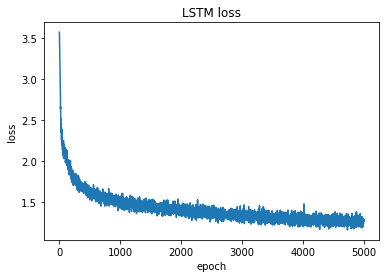

In [18]:
for i in range(5000):
    batch_ix = to_matrix(sample(data, 32), max_len=MAX_LENGTH)
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64)
    
    logp_seq = rnn_loop(model, batch_ix)
    
    # compute loss
    predictions_logp = logp_seq[:, :-1]
    actual_next_tokens = batch_ix[:, 1:]

    loss = criterion(predictions_logp.contiguous().view(-1, len(tokens)), actual_next_tokens.contiguous().view(-1))
    
    # train with backprop
    opt.zero_grad()
    loss.backward()
    opt.step()
    
    history.append(loss.data.numpy())
    if (i+1)%100==0:
        clear_output(True)
        plt.plot(history)
        plt.title("LSTM loss")
        plt.xlabel("epoch")
        plt.ylabel("loss")
        plt.show()

assert np.mean(history[:10]) > np.mean(history[-10:]), "RNN didn't converge."

Generate text using the trained net with different `temperature` parameter: `[0.1, 0.2, 0.5, 1.0, 2.0]`.

Evaluate the results visually, try to interpret them.

In [19]:
for _ in range(10):
    print(generate_sample(model, seed_phrase=' ', temperature=0.1))

 то в старины простов он             
 старит в страть в соборов и странный
 старит он он он он он               
 свое в старины простовой            
 старины простов он он               
 то в старины простов и стара        
 то в старины приворой               
 стал он он он он постал             
 старой старины простовой            
 та в старой привотельный стар       


In [20]:
for _ in range(10):
    print(generate_sample(model, seed_phrase=' ', temperature=0.2))

 старит и все старой странный        
 та мой страсти не в старани         
 старой страть он сердце стара       
 стара ответ и гостав                
 своей простов и в сободит           
 старины простов не поле             
 своей как не то мого                
 та страть в сердце пором сердце     
 та был он он он моей                
 стал он он поставал он              


In [21]:
for _ in range(10):
    print(generate_sample(model, seed_phrase=' ', temperature=0.5))

 спости на стало в старой            
 ворненье в росто на нем             
 с не стрател он и вет он            
 и не замета пора                    
 постит в послего как мов            
 то я на души своей                  
 и потом ставы в мой остал           
 ставели моей простой                
 мого девно в кременский что         
 его терей с не словой               


In [23]:
for _ in range(10):
    print(generate_sample(model, seed_phrase=' ', temperature=1.0))

 тем одушкно за мнерного             
 он все гостом вызанкив мжил         
 вешные зводительный дол             
 малыет злон мне очеши               
 оклоны плажарять визань             
 чечной том он холуке камла          
 уткой и развваистималь              
 ю эту постать ипах отда             
 оскамет покуповеть вета             
 ле гумок прушки зрам ответ          


In [24]:
for _ in range(10):
    print(generate_sample(model, seed_phrase=' ', temperature=2.0))

 чомрозрыху дошулпеях крустко        
 мицоюственновся чток рузклый мруковж
 набчиенчузь ни цлюная               
 проднафаь щыко бревах               
 одвмщиемы гду к провал              
 двлопчечкло бизна емзуним    с      
 кукубу бяесянно ык чныхы            
 эна што дъязклю нвазноропнтже       
 дадиньем ши туядма и                
 ях наря угровы важдщньимы           


$\textbf{Вывод:}$ при низких значениях температуры генирируемый текст не предрасположен к разнообразию, слова часто повторяются. В случае же высоких температур получается наоборот: последующие буквы генерируются словно рандомно и не выстраиваются в осмысленные слова. Хороший результат показали значения 0.5 и 1.0, наверно между ними как раз находится оптимальная величина для содержательного и неповторяющегося текста.

### Saving and loading models

Save the model to the disk, then load it and generate text. Examples are available [here](https://pytorch.org/tutorials/beginner/saving_loading_models.html]).

In [26]:
def save_checkpoint(checkpoint_path, model, optimizer):
    # state_dict: a Python dictionary object that:
    # - for a model, maps each layer to its parameter tensor;
    # - for an optimizer, contains info about the optimizer’s states and hyperparameters used.
    state = {
        'state_dict': model.state_dict(),
        'optimizer' : optimizer.state_dict()}
    torch.save(state, checkpoint_path)
    print(f'model saved to {checkpoint_path}')
    
def load_checkpoint(checkpoint_path, model, optimizer):
    state = torch.load(checkpoint_path)
    model.load_state_dict(state['state_dict'])
    optimizer.load_state_dict(state['optimizer'])
    print(f'model loaded from { checkpoint_path}')

$\textbf{Сохраняем:}$

In [27]:
save_checkpoint('mnist-1.pth', model, opt)

model saved to mnist-1.pth


$\textbf{Загружаем:}$

In [29]:
model = CharLSTMCell()
opt = torch.optim.Adam(model.parameters())
load_checkpoint('mnist-1.pth', model, opt)

model loaded from mnist-1.pth


$\textbf{Проверяем модель:}$

In [30]:
for _ in range(10):
    print(generate_sample(model, seed_phrase=' ', temperature=1.0))

  в чем торкого боздул долень        
 на не благошьрожеть устых           
 отчехте чум проканки волни          
 сталитья всем брага себав           
 об ужи ли твоеб себя                
 и дему прочем долгольный            
 смеслуг любенные моей               
 собрая плашный он жалац             
 пони шуманчю от вольвого            
 измебы пос горок храня              


In [32]:
for _ in range(10):
    print(generate_sample(model, seed_phrase=' ', temperature=0.7))

 свой наслигов опришельный           
 костольный старая татьяна           
  водишны бесны надов                
 смучлиным замертым настрочас        
 дово смерность долва сокровь        
 сиет евгет он следенные             
 которная гуду могов                 
 емодыло сердце                      
 замечатвенся увыхало                
 смолновый вас в смепать он          


### References
1. <a href='http://karpathy.github.io/2015/05/21/rnn-effectiveness/'> Andrew Karpathy blog post about RNN. </a> 
There are several examples of genration: Shakespeare texts, Latex formulas, Linux Sourse Code and children names.
2. <a href='https://github.com/karpathy/char-rnn'> Repo with char-rnn code </a>
3. Cool repo with PyTorch examples: [link](https://github.com/spro/practical-pytorch`)